In [2]:
# Importaciones necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Importaciones de scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer

# Importaciones de modelos adicionales
from xgboost import XGBRegressor

In [3]:
df_modelo = pd.read_csv('df_EDA_predicprecio.csv')
df_modelo.head()

,make,model,version,fuel,year,kms,power,shift,price
0,Opel,Crossland,1.2 GAS 110 GS Line 5p S/S,Gasolina,2022,5.0,110.0,manual,22900
1,Opel,Crossland,1.2 81kW (110CV) GS Line,Gasolina,2022,24847.0,110.0,manual,19990
2,Opel,Crossland,1.5D 88kW (120CV) Business Elegance Auto,Diésel,2021,41356.0,120.0,automatic,18590
3,Opel,Crossland,GS-Line 1.2 GAS MT6 S/S 110cv,Gasolina,2022,11.0,110.0,manual,22700
4,Opel,Crossland,1.2 GS LINE 110 CV 5P,Gasolina,2021,51390.0,110.0,manual,18200


In [4]:
df_modelo.shape

(12453, 9)

In [5]:
df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12453 entries, 0 to 12452
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   make     12453 non-null  object 
 1   model    12453 non-null  object 
 2   version  12453 non-null  object 
 3   fuel     12453 non-null  object 
 4   year     12453 non-null  int64  
 5   kms      12453 non-null  float64
 6   power    12453 non-null  float64
 7   shift    12453 non-null  object 
 8   price    12453 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 875.7+ KB


In [6]:
# Función de normalización ajustada
def normalize_version(row):
    version = row['version']
    year = row['year']
    
    # Paso 1: Convertir todo a minúsculas
    version = version.lower()
    
    # Paso 2: Eliminar paréntesis y unidades de potencia como CV, kW
    version = re.sub(r'\s*\(?\d+\s*(cv|kw)\)?\s*', '', version)
    
    # Paso 3: Normalizar palabras clave de combustible
    version = re.sub(r'\bgas\b', 'gasolina', version)
    version = re.sub(r'\bdiesel\b', 'diésel', version)
    
    # Paso 4: Eliminar abreviaturas de transmisión y tipo (MT6, S/S, 5p, auto, manual, etc.)
    version = re.sub(r'\b(mt6|s/s|5p|automatico|manual|auto|edition|line|style|pro|exclusive|gs-line)\b', '', version)
    
    # Paso 5: Eliminar texto que no aporta a la versión, como "cv" o "kw"
    version = re.sub(r'\b(cv|kw)\b', '', version)
    
    # Paso 6: Eliminar caracteres de puntuación innecesarios y espacios adicionales
    version = re.sub(r'\s+', ' ', version)  # Reemplazar múltiples espacios por uno solo
    version = re.sub(r'[^\w\s]', '', version)  # Eliminar caracteres no alfanuméricos (por ejemplo, guiones, paréntesis)
    
    # Paso 7: Eliminar espacios al principio y al final
    version = version.strip()
    
    # Incluir el año en la versión normalizada
    normalized_version = f"{version} {year}"
    
    return normalized_version

# Aplicar la normalización incluyendo el año directamente en df_modelo
df_modelo['normalized_version'] = df_modelo.apply(normalize_version, axis=1)

In [7]:
# Número de filas antes de eliminar duplicados
initial_rows = len(df_modelo)

# Eliminar duplicados basados en 'make', 'model' y 'normalized_version'
df_modelo = df_modelo.drop_duplicates(subset=['make', 'model', 'normalized_version'])

# Número de filas después de eliminar duplicados
final_rows = len(df_modelo)

# Número de filas eliminadas
deleted_rows = initial_rows - final_rows

print(f"\nNúmero de filas originales: {initial_rows}")
print(f"Número de filas después de eliminar duplicados: {final_rows}")
print(f"Número de filas eliminadas: {deleted_rows}")


Número de filas originales: 12453
Número de filas después de eliminar duplicados: 9010
Número de filas eliminadas: 3443


In [8]:
def preprocesar_datos(df):
    # Separar características y variable objetivo
    X = df.drop('price', axis=1)
    y = df['price']
    
    # Identificar columnas categóricas y numéricas
    columnas_categoricas = ['make', 'model', 'version', 'fuel', 'shift']
    columnas_numericas = ['year', 'kms', 'power']
    
    # Crear transformador de columnas
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), columnas_numericas),
            ('cat', OneHotEncoder(handle_unknown='ignore'), columnas_categoricas)
        ])
    
    return X, y, preprocessor

In [9]:
# Paso 3: Dividir los datos en entrenamiento y prueba
def dividir_datos(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    return X_train, X_test, y_train, y_test


In [10]:
# Paso 4: Crear y entrenar el modelo
def crear_modelo(preprocessor):
    modelo = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
    return modelo

In [11]:
# Paso 5: Evaluar el modelo
def evaluar_modelo(modelo, X_test, y_test):
    predicciones = modelo.predict(X_test)
    
    mse = mean_squared_error(y_test, predicciones)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predicciones)
    r2 = r2_score(y_test, predicciones)
    
    print("Métricas de evaluación:")
    print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
    print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}")
    print(f"Error Absoluto Medio (MAE): {mae:.2f}")
    print(f"Coeficiente de Determinación (R²): {r2:.2f}")
    
    return predicciones

In [12]:
# Función principal para ejecutar todo el proceso
def main(df):
    # Paso 2: Preprocesar datos
    X, y, preprocessor = preprocesar_datos(df)
    
    # Paso 3: Dividir datos
    X_train, X_test, y_train, y_test = dividir_datos(X, y)
    
    # Paso 4: Crear modelo
    modelo = crear_modelo(preprocessor)
    modelo.fit(X_train, y_train)
    
    # Paso 5: Evaluar modelo
    predicciones = evaluar_modelo(modelo, X_test, y_test)
    
    return modelo, predicciones

In [13]:
modelo = main(df_modelo)

Métricas de evaluación:
Error Cuadrático Medio (MSE): 102262566.49
Raíz del Error Cuadrático Medio (RMSE): 10112.50
Error Absoluto Medio (MAE): 4043.89
Coeficiente de Determinación (R²): 0.81


In [14]:
# Función de depuración de valores infinitos
def depurar_valores_infinitos(X):
    """
    Depura valores infinitos separando columnas numéricas y categóricas
    
    Parámetros:
    X (DataFrame): DataFrame de entrada
    
    Retorna:
    DataFrame procesado
    """
    # Separar columnas numéricas y categóricas
    columnas_numericas = X.select_dtypes(include=['int64', 'float64']).columns
    columnas_categoricas = X.select_dtypes(include=['object']).columns
    
    # Clonar el DataFrame
    X_depurado = X.copy()
    
    # Imputar columnas numéricas
    if len(columnas_numericas) > 0:
        # Convertir infinitos a NaN
        X_depurado[columnas_numericas] = X_depurado[columnas_numericas].replace([np.inf, -np.inf], np.nan)
        
        # Imputar valores NaN con la mediana
        imputer_numerico = SimpleImputer(strategy='median')
        X_depurado[columnas_numericas] = imputer_numerico.fit_transform(X_depurado[columnas_numericas])
    
    # Imputar columnas categóricas con el valor más frecuente
    if len(columnas_categoricas) > 0:
        imputer_categorico = SimpleImputer(strategy='most_frequent')
        X_depurado[columnas_categoricas] = imputer_categorico.fit_transform(X_depurado[columnas_categoricas])
    
    return X_depurado

In [15]:
# Función de creación segura de características
def crear_caracteristicas_seguras(df):
    """
    Crea características nuevas manejando casos especiales
    
    Parámetros:
    df (DataFrame): DataFrame original
    
    Retorna:
    DataFrame con nuevas características
    """
    # Clonar el dataframe para no modificar el original
    df_seguro = df.copy()
    
    # Manejar casos de car_age = 0
    df_seguro['car_age'] = 2024 - df_seguro['year']
    df_seguro.loc[df_seguro['car_age'] == 0, 'car_age'] = 1  # Evitar división por cero
    
    # Calcular kms_per_year con manejo de casos especiales
    df_seguro['kms_per_year'] = df_seguro['kms'] / df_seguro['car_age']
    
    # Manejar casos extremos de kms_per_year
    kms_per_year_mean = df_seguro['kms_per_year'].median()
    df_seguro.loc[np.isinf(df_seguro['kms_per_year']), 'kms_per_year'] = kms_per_year_mean
    
    # Calcular power_per_km con manejo de casos especiales
    df_seguro['power_per_km'] = df_seguro['power'] / df_seguro['kms']
    power_per_km_mean = df_seguro['power_per_km'].median()
    df_seguro.loc[np.isinf(df_seguro['power_per_km']), 'power_per_km'] = power_per_km_mean
    
    return df_seguro


In [16]:
# Paso 1: Aplicar función de características
df_modelo = crear_caracteristicas_seguras(df_modelo)

In [17]:
# Paso 2: Depuración inicial de todo el dataset
df_modelo = depurar_valores_infinitos(df_modelo)

In [18]:
# Paso 3: Identificar columnas
columnas_categoricas = ['make', 'model', 'version', 'fuel', 'shift']
columnas_numericas = ['year', 'kms', 'power', 'car_age', 'kms_per_year', 'power_per_km']

In [19]:
# Paso 6: Preparación de datos
# Separar características y objetivo
X = df_modelo.drop('price', axis=1)
y = df_modelo['price']

In [20]:
# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Paso 7: Preprocesador robusto
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), columnas_numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore'), columnas_categoricas)
    ])

In [22]:
# Paso 8: Definir modelos para comparación
modelos = {
    'RandomForest': {
        'modelo': RandomForestRegressor(random_state=42),
        'parametros': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    'GradientBoosting': {
        'modelo': GradientBoostingRegressor(random_state=42),
        'parametros': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    }
}

In [ ]:
# Inicializar un diccionario para guardar los resultados
resultados_modelos = {}

# Depurar valores infinitos una vez
X_train_depurado = depurar_valores_infinitos(X_train)
X_test_depurado = depurar_valores_infinitos(X_test)

# Iterar sobre cada modelo definido
for nombre, config in modelos.items():
    # Crear pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', config['modelo'])
    ])
    
    # Grid Search con validación cruzada repetida
    grid_search = GridSearchCV(
        pipeline, 
        param_grid={f'regressor__{k}': v for k, v in config['parametros'].items()}, 
        cv=RepeatedKFold(n_splits=5, n_repeats=3),
        scoring='neg_mean_squared_error'
    )

    # Entrenar el modelo
    grid_search.fit(X_train_depurado, y_train)

In [ ]:
# Mejores parámetros
print(f"\nMejores parámetros para {nombre}:")
print(grid_search.best_params_)
    
# Predicciones
X_test_depurado = depurar_valores_infinitos(X_test)
predicciones = grid_search.predict(X_test_depurado)
    
# Métricas
mse = mean_squared_error(y_test, predicciones)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predicciones)
r2 = r2_score(y_test, predicciones)
    
resultados_modelos[nombre] = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'Modelo': grid_search
}

print("\nMétricas de Rendimiento:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")



Mejores parámetros para GradientBoosting:
{'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 200}

Métricas de Rendimiento:
Mean Squared Error (MSE): 97283867.58179395
Root Mean Squared Error (RMSE): 9863.258466743835
Mean Absolute Error (MAE): 4194.603529148058
R² Score: 0.8202392853006649


In [ ]:
# Paso 10: Seleccionar mejor modelo
mejor_modelo_nombre = max(resultados_modelos, key=lambda x: resultados_modelos[x]['R2'])
mejor_modelo = resultados_modelos[mejor_modelo_nombre]['Modelo']

print(f"\nMejor Modelo: {mejor_modelo_nombre}")
print(f"R² Score: {resultados_modelos[mejor_modelo_nombre]['R2']:.4f}")


Mejor Modelo: GradientBoosting
R² Score: 0.8202


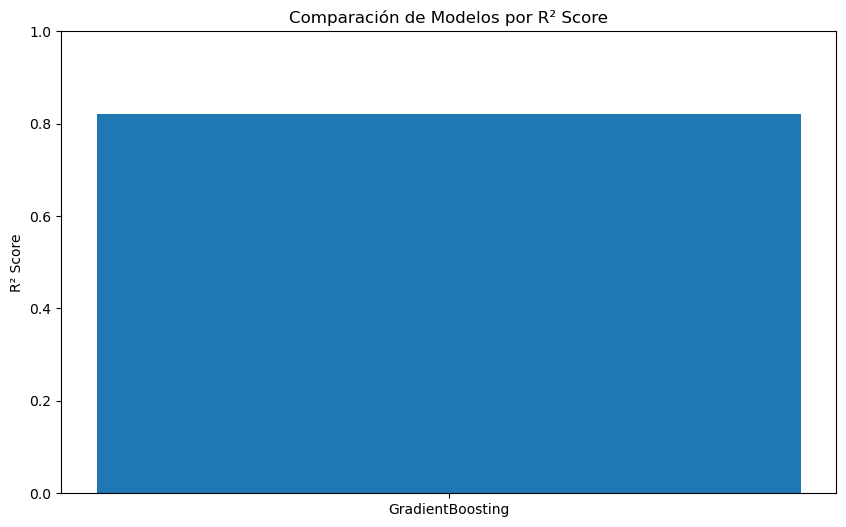

<Figure size 1500x1000 with 0 Axes>

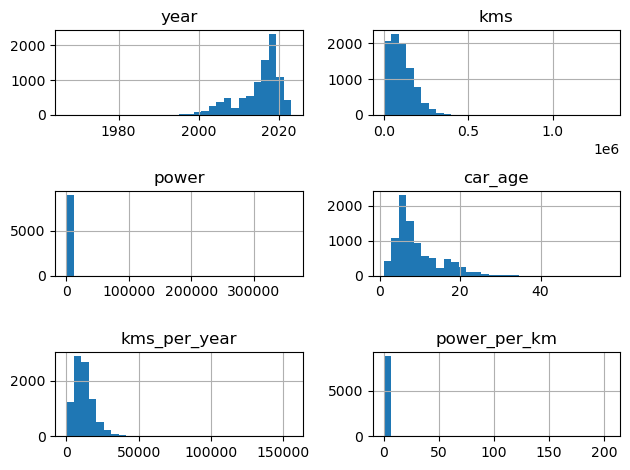

In [ ]:
# Paso 11: Visualización de resultados
plt.figure(figsize=(10, 6))
plt.bar(resultados_modelos.keys(), 
        [resultados_modelos[modelo]['R2'] for modelo in resultados_modelos.keys()])
plt.title('Comparación de Modelos por R² Score')
plt.ylabel('R² Score')
plt.ylim(0, 1)
plt.show()

# Paso adicional: Diagnóstico de características
plt.figure(figsize=(15,10))
df_modelo[columnas_numericas].hist(bins=30)
plt.tight_layout()
plt.show()

In [ ]:
# Imprimir información detallada
print("\nEstadísticas de características:")
print(df_modelo[columnas_numericas].describe())


Estadísticas de características:
              year           kms          power      car_age   kms_per_year  \
count  9010.000000  9.010000e+03    9010.000000  9010.000000    9010.000000   
mean   2014.945394  1.040631e+05     192.266038     9.054606   11903.058282   
std       5.607991  7.556553e+04    3798.192970     5.607991    7268.095885   
min    1967.000000  0.000000e+00       0.000000     1.000000       0.000000   
25%    2012.000000  4.837475e+04     100.000000     5.000000    7274.458333   
50%    2017.000000  9.214100e+04     129.000000     7.000000   10939.338235   
75%    2019.000000  1.450000e+05     160.000000    12.000000   15384.615385   
max    2023.000000  1.330000e+06  360571.000000    57.000000  155463.500000   

       power_per_km  
count   9010.000000  
mean       0.815207  
std        9.213427  
min        0.000000  
25%        0.000855  
50%        0.001443  
75%        0.003001  
max      204.000000  


In [ ]:
# Función de depuración de valores infinitos
def depurar_valores_infinitos(X):
    """
    Depura valores infinitos separando columnas numéricas y categóricas
    
    Parámetros:
    X (DataFrame): DataFrame de entrada
    
    Retorna:
    DataFrame procesado
    """
    # Separar columnas numéricas y categóricas
    columnas_numericas = X.select_dtypes(include=['int64', 'float64']).columns
    columnas_categoricas = X.select_dtypes(include=['object']).columns
    
    # Clonar el DataFrame
    X_depurado = X.copy()
    
    # Imputar columnas numéricas
    if len(columnas_numericas) > 0:
        # Convertir infinitos a NaN
        X_depurado[columnas_numericas] = X_depurado[columnas_numericas].replace([np.inf, -np.inf], np.nan)
        
        # Imputar valores NaN con la mediana
        imputer_numerico = SimpleImputer(strategy='median')
        X_depurado[columnas_numericas] = imputer_numerico.fit_transform(X_depurado[columnas_numericas])
    
    # Imputar columnas categóricas con el valor más frecuente
    if len(columnas_categoricas) > 0:
        imputer_categorico = SimpleImputer(strategy='most_frequent')
        X_depurado[columnas_categoricas] = imputer_categorico.fit_transform(X_depurado[columnas_categoricas])
    
    return X_depurado


In [ ]:
# Función de identificación y manejo de outliers
def identificar_outliers(df, columna):
    """
    Identifica y filtra outliers usando el método del rango intercuartílico
    
    Parámetros:
    df (DataFrame): DataFrame de entrada
    columna (str): Nombre de la columna a analizar
    
    Retorna:
    DataFrame sin outliers
    """
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    return df[(df[columna] >= limite_inferior) & (df[columna] <= limite_superior)]

In [ ]:
# Función de creación de características avanzadas
def crear_caracteristicas_avanzadas(df):
    """
    Crea características nuevas y categorías
    
    Parámetros:
    df (DataFrame): DataFrame original
    
    Retorna:
    DataFrame con nuevas características
    """
    df_caracteristicas = df.copy()
    
    # Características existentes
    df_caracteristicas['car_age'] = 2024 - df_caracteristicas['year']
    df_caracteristicas.loc[df_caracteristicas['car_age'] == 0, 'car_age'] = 1
    
    # Nuevas características
    df_caracteristicas['kms_per_year'] = df_caracteristicas['kms'] / df_caracteristicas['car_age']
    df_caracteristicas['power_per_km'] = df_caracteristicas['power'] / df_caracteristicas['kms']
    df_caracteristicas['power_to_kms_ratio'] = df_caracteristicas['power'] / (df_caracteristicas['kms'] + 1)
    
    # Categorías
    df_caracteristicas['age_category'] = pd.cut(
        df_caracteristicas['car_age'], 
        bins=[0, 3, 6, 10, 15, 100], 
        labels=['New', 'Recent', 'Used', 'Old', 'Vintage']
    )
    
    df_caracteristicas['kms_category'] = pd.cut(
        df_caracteristicas['kms'], 
        bins=[0, 50000, 100000, 200000, np.inf], 
        labels=['Low', 'Medium', 'High', 'Very High']
    )
    
    return df_caracteristicas

In [ ]:
# Función para plotear importancia de características
def plot_feature_importance(model, feature_names):
    """
    Plotea la importancia de las características
    
    Parámetros:
    model: Modelo entrenado
    feature_names: Nombres de características
    """
    # Obtener importancia de características
    importances = model.named_steps['regressor'].feature_importances_
    
    # Crear DataFrame de importancias
    feature_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # Visualizar
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_imp.head(10))
    plt.title('Top 10 Features by Importance')
    plt.tight_layout()
    plt.show()

In [ ]:
# Paso 1: Preprocesamiento de datos
# Aplicar creación de características avanzadas
df_modelo = crear_caracteristicas_avanzadas(df_modelo)

In [ ]:
# Filtrar outliers
df_modelo = identificar_outliers(df_modelo, 'price')

In [ ]:
# Depuración inicial de todo el dataset
df_modelo = depurar_valores_infinitos(df_modelo)

In [ ]:
# Paso 2: Definir columnas
columnas_categoricas = ['make', 'model', 'version', 'fuel', 'shift', 
                        'age_category', 'kms_category']
columnas_numericas = ['year', 'kms', 'power', 'car_age', 'kms_per_year', 
                      'power_per_km', 'power_to_kms_ratio']

In [ ]:
# Paso 3: Preparación de datos
# Separar características y objetivo
X = df_modelo.drop('price', axis=1)
y = df_modelo['price']


In [ ]:
# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Paso 4: Preprocesador robusto
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), columnas_numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore'), columnas_categoricas)
    ])


In [ ]:
# Paso 5: Definir modelos con hiperparámetros expansivos
modelos = {
    'RandomForest': {
        'modelo': RandomForestRegressor(random_state=42),
        'parametros': {
            'n_estimators': [100, 200, 300, 400],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10, 15],
            'max_features': ['auto', 'sqrt', 'log2'],
            'bootstrap': [True, False]
        }
    },
    'GradientBoosting': {
        'modelo': GradientBoostingRegressor(random_state=42),
        'parametros': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 4, 5],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'subsample': [0.8, 0.9, 1.0]
        }
    },
    'XGBoost': {
        'modelo': XGBRegressor(random_state=42),
        'parametros': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 4, 5],
            'min_child_weight': [1, 3, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0]
        }
    }
}


In [ ]:
# Inicializar un diccionario para guardar los resultados
resultados_modelos = {}

# Depurar valores infinitos una vez
X_train_depurado = depurar_valores_infinitos(X_train)
X_test_depurado = depurar_valores_infinitos(X_test)

# Iterar sobre cada modelo definido
for nombre, config in modelos.items():
    # Crear pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', config['modelo'])
    ])
    
    # Grid Search con validación cruzada repetida
    grid_search = GridSearchCV(
        pipeline, 
        param_grid={f'regressor__{k}': v for k, v in config['parametros'].items()}, 
        cv=RepeatedKFold(n_splits=5, n_repeats=3),
        scoring='neg_mean_squared_error'
    )

    # Entrenar el modelo
    grid_search.fit(X_train_depurado, y_train)

In [ ]:
# Entrenar con datos depurados
#X_train_depurado = depurar_valores_infinitos(X_train)
#grid_search.fit(X_train_depurado, y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         RobustScaler(),
                                                                         ['year',
                                                                          'kms',
                                                                          'power',
                                                                          'car_age',
                                                                          'kms_per_year',
                                                                          'power_per_km',
                                                                          'power_to_kms_ratio']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['make',
                                                                          'model',
                                                                          'version',
                                                                          'fuel',
                                                                          'shift',
                                                                          'age_categ...
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             param_grid={'regressor__colsample_bytree': [0.6, 0.8, 1.0],
                         'regressor__learning_rate': [0.01, 0.1, 0.2],
                         'regressor__max_depth': [3, 4, 5],
                         'regressor__min_child_weight': [1, 3, 5],
                         'regressor__n_estimators': [100, 200, 300],
                         'regressor__subsample': [0.6, 0.8, 1.0]},
             scoring='neg_mean_squared_error')

In [ ]:
# Mejores parámetros
print(f"\nMejores parámetros para {nombre}:")
print(grid_search.best_params_)

# Predicciones
X_test_depurado = depurar_valores_infinitos(X_test)
predicciones = grid_search.predict(X_test_depurado)
    
# Métricas
mse = mean_squared_error(y_test, predicciones)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predicciones)
r2 = r2_score(y_test, predicciones)
    
resultados_modelos[nombre] = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2,
    'Modelo': grid_search
}

print("\nMétricas de Rendimiento:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")


Mejores parámetros para XGBoost:
{'regressor__colsample_bytree': 0.6, 'regressor__learning_rate': 0.2, 'regressor__max_depth': 5, 'regressor__min_child_weight': 1, 'regressor__n_estimators': 300, 'regressor__subsample': 0.8}

Métricas de Rendimiento:
Mean Squared Error (MSE): 17865878.50272495
Root Mean Squared Error (RMSE): 4226.8047627877195
Mean Absolute Error (MAE): 2589.068746815557
R² Score: 0.8014952849136961


In [ ]:
# Paso 7: Seleccionar mejor modelo
mejor_modelo_nombre = max(resultados_modelos, key=lambda x: resultados_modelos[x]['R2'])
mejor_modelo = resultados_modelos[mejor_modelo_nombre]['Modelo']

print(f"\nMejor Modelo: {mejor_modelo_nombre}")
print(f"R² Score: {resultados_modelos[mejor_modelo_nombre]['R2']:.4f}")


Mejor Modelo: XGBoost
R² Score: 0.8015


In [ ]:
# Imprimir los nombres en los diccionarios para verificar
print("Nombres en modelos:")
print(list(modelos.keys()))

print("\nNombres en resultados_modelos:")
print(list(resultados_modelos.keys()))

# Mapeo de nombres si es necesario
nombre_mapeo = {
    'RandomForest': 'Random Forest',
    'GradientBoosting': 'Gradient Boosting',
    'XGBoost': 'XGBoost'
}

# Crear el ensemble con mapeo de nombres
ensemble_modelos = []
for nombre_clave, nombre_resultado in nombre_mapeo.items():
    try:
        modelo = modelos[nombre_clave]['modelo'].set_params(
            **resultados_modelos[nombre_resultado]['Modelo'].best_params_
        )
        ensemble_modelos.append((nombre_clave, modelo))
    except KeyError as e:
        print(f"Error con el modelo {nombre_clave}: {e}")

Nombres en modelos:
['RandomForest', 'GradientBoosting', 'XGBoost']

Nombres en resultados_modelos:
['XGBoost']
Error con el modelo RandomForest: 'Random Forest'
Error con el modelo GradientBoosting: 'Gradient Boosting'


In [ ]:
# Crear el ensemble con mapeo de nombres
ensemble_modelos = []
for nombre_clave, nombre_resultado in nombre_mapeo.items():
    try:
        modelo = modelos[nombre_clave]['modelo'].set_params(
            **resultados_modelos[nombre_resultado]['Modelo'].best_params_
        )
        ensemble_modelos.append((nombre_clave, modelo))
    except KeyError as e:
        print(f"Error con el modelo {nombre_clave}: {e}")

Error con el modelo RandomForest: 'Random Forest'
Error con el modelo GradientBoosting: 'Gradient Boosting'


In [ ]:
# Paso 8: Ensemble de Modelos
# Crear el ensemble
# Suponiendo que 'resultados_modelos' contiene los resultados de grid search
ensemble_modelos = [
    ('rf', modelos['RandomForest']['modelo'].set_params(**resultados_modelos['RandomForest']['Modelo'].best_params_)),
    ('gb', modelos['GradientBoosting']['modelo'].set_params(**resultados_modelos['GradientBoosting']['Modelo'].best_params_)),
    ('xgb', modelos['XGBoost']['modelo'].set_params(**resultados_modelos['XGBoost']['Modelo'].best_params_))
]

KeyError: 'RandomForest'

In [ ]:
ensemble = VotingRegressor(ensemble_modelos)

In [ ]:
# Pipeline para el ensemble
ensemble_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', ensemble)
])


In [ ]:
# Entrenar ensemble
ensemble_pipeline.fit(X_train_depurado, y_train)


c:\Users\Gema\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:26:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "regressor__colsample_bytree", "regressor__learning_rate", "regressor__max_depth", "regressor__min_child_weight", "regressor__n_estimators", "regressor__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  ['year', 'kms', 'power',
                                                   'car_age', 'kms_per_year',
                                                   'power_per_km',
                                                   'power_to_kms_ratio']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['make', 'model', 'version',
                                                   'fuel', 'shift',
                                                   'age_category',
                                                   'kms_category'])])),
                ('regressor',
                 VotingRegressor(estimators=[('XGBoost',
                                              XGBRe...
                                                           grow_policy=None,
                                                           importance_type=None,
                                                           interaction_constraints=None,
                                                           learning_rate=None,
                                                           max_bin=None,
                                                           max_cat_threshold=None,
                                                           max_cat_to_onehot=None,
                                                           max_delta_step=None,
                                                           max_depth=None,
                                                           max_leaves=None,
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=None,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=42, ...))]))])

In [ ]:
# Predicciones del ensemble
predicciones_ensemble = ensemble_pipeline.predict(X_test_depurado)

# Métricas del ensemble
mse_ensemble = mean_squared_error(y_test, predicciones_ensemble)
rmse_ensemble = np.sqrt(mse_ensemble)
mae_ensemble = mean_absolute_error(y_test, predicciones_ensemble)
r2_ensemble = r2_score(y_test, predicciones_ensemble)

print("\nEnsemble Model Results:")
print(f"R² Score: {r2_ensemble:.4f}")
print(f"RMSE: {rmse_ensemble:.2f}")
print(f"MAE: {mae_ensemble:.2f}")


Ensemble Model Results:
R² Score: 0.7936
RMSE: 4310.44
MAE: 2703.28


In [ ]:
# Paso 10: Importancia de características
plot_feature_importance(mejor_modelo, 
    preprocessor.get_feature_names_out())

AttributeError: 'GridSearchCV' object has no attribute 'named_steps'